# Description

This notebook is used to tabulate final results and compare novel generated molecules vs HIV inhibitors vs Remdesivir which entered clinical trials just a few days ago.

## Now the best results and save to sdf for last double check tabulation in PyRx

In [11]:
import pandas as pd
from rdkit import Chem, DataStructs
import random
import numpy as np
import rdkit.Chem.PropertyMol

In [12]:
# './generations/master_results_table_gen10.csv'

final = pd.read_csv('./generations/master_results_table_gen17.csv',sep=',')
final = final.sort_values('score', ascending=True)
print(final.shape)
final.head()

(18364, 7)


,id,gen,smile,source,weight,logp,score
0,ACLT,17,CC1CCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCC2CC...,generated,1354.571,36.8575,-17.0
1,ACDH,17,CC1C=CCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCC...,generated,1470.734,39.2484,-16.9
2,ABKH,16,CC1CCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCC2CCC...,generated,1338.443,35.0655,-16.8
3,ACLV,17,CC1CCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCC2CCC...,generated,1298.463,35.2971,-16.8
4,ABWF,16,CC1CCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCC2CC...,generated,1342.390,34.3356,-16.7


In [13]:
final_max = final.groupby("smile").max()[["score","gen"]].reset_index()
final_max = final_max.sort_values('score', ascending=True)
print(final_max.shape)
final_max.head()

(18300, 3)


,smile,score,gen
9806,CC1CCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCC2CC...,-17.0,17
8129,CC1C=CCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCC...,-16.9,17
9760,CC1CCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCC2CCC...,-16.8,16
9765,CC1CCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCC2CCC...,-16.8,17
9795,CC1CCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCC2CC...,-16.7,16


In [14]:
final_joined = pd.merge(final_max, final, on=['smile','gen'], suffixes=('_old','_new'), how='left')

# final_joined = final_joined[(final_joined['score_new'] <= -15.0) & (final_joined['weight'] < 900)]
final_joined = final_joined[(final_joined['score_new'] <= -7.8) & (final_joined['logp']<5)]

final_joined['score'] = final_joined['score_new']
final_joined = final_joined.drop('score_old', axis=1)
final_joined = final_joined.drop('score_new', axis=1)
print(final_joined.shape)
final_joined.head(5)

(2492, 7)


,smile,gen,id,source,weight,logp,score
790,CC(=O)Nc1nnnn1C1=CC=CC(C(=O)Nc2nnnn2N2C=NN=NN2...,17,ABZY,generated,918.713,-2.58760,-13.3
824,CC1C=CC=C(C(=O)Nc2nnnn2N2CCN(C(=O)Nc3nnnnn3)C2...,12,ABQA,generated,815.779,2.33710,-13.3
878,Cc1ccc(C(=O)Nc2nnnn2N2C=NN=NN2N2CCN(C(=O)Nc3nn...,16,AAXQ,generated,696.656,3.15662,-13.2
885,CC1CCCCC(C(=O)Nc2nnnn2N2C=NN=NN2N2C=NN=NN2N2C=...,17,ABPW,generated,902.754,-0.40890,-13.2
966,CC1CCCC(C(=O)Nc2nnnn2N2C=NN=NN2N2C=NN=NN2N2CCN...,16,ABCA,generated,721.671,1.44670,-13.1


#### Note I also manually added Remdesivir because as working on this it went into clinical trials
###https://en.wikipedia.org/wiki/Remdesivir

final_table.to_csv(r'./generations/master_results_table_final.csv', index=False)

final_table = pd.read_csv('./generations/master_results_table_final.csv')
final_table.tail()

In [16]:
def set_molecule(row):
    mol = Chem.MolFromSmiles(row['smile'])
    pm = Chem.PropertyMol.PropertyMol(mol)
    title = 'id' + str(row['id']) + 'gen'+ str(row['gen'])
    # print(title)
    # Enables for tracking which molecule is which in PyRx GUI and PyRx results export
    pm.SetProp('Title', title)
    return pm

mols_for_export = final_table.apply(set_molecule, axis=1)
### list(mols_for_export)

len(mols_for_export)

w = Chem.SDWriter('./generations/genfinal.sdf')
for m in mols_for_export:
    w.write(m)

# Rerun everything through PyRx once more to double check, then publish final metrics

In [82]:
dfs = []

# new_scores = pd.read_csv('./generations/results/results_gen12.csv',sep=',')

current_gen = 17
for i in range(0, current_gen+1):
    dfs.append(pd.read_csv('./generations/results/results_gen' + str(i) +'.csv',sep=','))

# Concatenate all data into one DataFrame
new_scores = pd.concat(dfs, ignore_index=True)

In [83]:
# new_scores = pd.read_csv('./generations/results/results_genfinal.csv',sep=',')
final_table = pd.read_csv('./generations/master_results_table_gen' + str(current_gen) +'.csv')
new_scores.head()

,Ligand,Binding Affinity,rmsd/ub,rmsd/lb
0,6lu7_idAAAAgen0,-6.7,0.000,0.000
1,6lu7_idAAAAgen0,-6.6,2.125,1.628
2,6lu7_idAAAAgen0,-6.4,9.023,3.692
3,6lu7_idAAAAgen0,-6.4,6.626,3.987
4,6lu7_idAAAAgen0,-6.3,6.182,4.837


In [84]:
new_scores = new_scores.groupby("Ligand").agg({'Binding Affinity': [np.min,np.average]}).reset_index()
new_scores.head()

Ligand Binding Affinity           
                                              amin    average
0   6LU7_idAAAAgen10_uff_E=112.89             -4.8  -4.511111
1   6LU7_idAAAAgen10_uff_E=178.91             -4.7  -4.377778
2  6LU7_idAAAAgen11_uff_E=3389.13            -11.0 -10.255556
3    6LU7_idAAAAgen11_uff_E=95.55             -4.1  -3.877778
4    6LU7_idAAAAgen12_uff_E=-0.64             -3.2  -3.000000

In [85]:
new_scores['id'] = new_scores['Ligand'].str.split("_").str[1].str.split("gen").str[0].str.split("id").str[1]
new_scores['gen'] = new_scores['Ligand'].str.split("_").str[1].str.split("gen").str[1]
new_scores['score_best'] = new_scores["Binding Affinity"]["amin"]
new_scores['score_avg'] = new_scores["Binding Affinity"]["average"]
new_scores = new_scores[['id','gen','score_best','score_avg']]

new_scores.head()
new_scores.dropna()

,id,gen,score_best,score_avg
,,,,
0,AAAA,10,-4.8,-4.511111
1,AAAA,10,-4.7,-4.377778
2,AAAA,11,-11.0,-10.255556
3,AAAA,11,-4.1,-3.877778
4,AAAA,12,-3.2,-3.000000
...,...,...,...,...
21253,ABTC,0,-7.8,-7.088889
21254,ABTD,0,-6.5,-6.144444
21255,ABTE,0,-7.9,-7.488889


In [86]:
final_table = final_table[final_table.score != 99.9]

In [87]:
final_table.describe()

,gen,weight,logp,score
count,16841.000000,16841.000000,16841.000000,16841.000000
mean,8.623716,525.423376,9.270852,-7.885981
std,5.603923,443.699514,13.512628,3.205921
min,0.000000,28.054000,-9.704780,-17.000000
25%,4.000000,196.250000,1.319800,-10.700000
50%,9.000000,337.347000,2.575100,-7.000000
75%,13.000000,691.756000,8.215900,-5.300000
max,17.000000,1767.402000,49.152600,19.900000


In [88]:
new_scores.id = new_scores.id.astype(str)
new_scores.gen = new_scores.gen.astype(str)

final_table.id = final_table.id.astype(str)
final_table.gen = final_table.gen.astype(str)

In [89]:
new_table = pd.merge(final_table, new_scores, on=['id','gen'], suffixes=('_old','_new'), how='left')
new_table['score_best'] = new_table[('score_best', '')]
new_table['score_avg'] = new_table[('score_avg', '')]

new_table = new_table.drop([('score_best', ''),('score_avg', '')], axis=1)
new_table = new_table.sort_values('score_best', ascending=True)

new_table.dropna()
new_table.head()

C:\Users\user\Anaconda3\envs\tfv2\lib\site-packages\pandas\core\reshape\merge.py:618: UserWarning: merging between different levels can give an unintended result (1 levels on the left, 2 on the right)
  warnings.warn(msg, UserWarning)


,id,gen,smile,source,weight,logp,score,score_best,score_avg
0,ACLT,17,CC1CCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCC2CC...,generated,1354.571,36.8575,-17.0,-17.0,-16.850
1,ACDH,17,CC1C=CCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCC...,generated,1470.734,39.2484,-16.9,-16.9,-16.750
2,ABKH,16,CC1CCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCC2CCC...,generated,1338.443,35.0655,-16.8,-16.8,-15.175
3,ACLV,17,CC1CCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCC2CCC...,generated,1298.463,35.2971,-16.8,-16.8,-16.750
4,ABWF,16,CC1CCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCC2CC...,generated,1342.390,34.3356,-16.7,-16.7,-16.300


In [90]:
new_table = pd.merge(final_table, new_scores, on=['id','gen'], suffixes=('_old','_new'), how='left')

new_table['score_best'] = new_table[('score_best', '')]
new_table['score_avg'] = new_table[('score_avg', '')]

new_table = new_table.drop([('score_best', ''),('score_avg', '')], axis=1)
new_table = new_table.sort_values('score_best', ascending=True)

new_table.dropna()
new_table.head(100)

C:\Users\user\Anaconda3\envs\tfv2\lib\site-packages\pandas\core\reshape\merge.py:618: UserWarning: merging between different levels can give an unintended result (1 levels on the left, 2 on the right)
  warnings.warn(msg, UserWarning)


,id,gen,smile,source,weight,logp,score,score_best,score_avg
0,ACLT,17,CC1CCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCC2CC...,generated,1354.571,36.8575,-17.0,-17.0,-16.850000
1,ACDH,17,CC1C=CCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCC...,generated,1470.734,39.2484,-16.9,-16.9,-16.750000
2,ABKH,16,CC1CCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCC2CCC...,generated,1338.443,35.0655,-16.8,-16.8,-15.175000
3,ACLV,17,CC1CCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCC2CCC...,generated,1298.463,35.2971,-16.8,-16.8,-16.750000
4,ABWF,16,CC1CCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCC2CC...,generated,1342.390,34.3356,-16.7,-16.7,-16.300000
...,...,...,...,...,...,...,...,...,...
100,AAON,15,CC1CCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCC...,generated,1258.313,33.1729,-15.1,-15.1,-13.375000
98,ACAH,16,CC1CCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCC...,generated,1318.283,32.8255,-15.1,-15.1,-13.014286
92,AAIR,12,CC1CCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCC...,generated,1324.501,35.8533,-15.1,-15.1,-13.366667
96,ACOV,17,CC1CCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCC...,generated,1490.724,39.5350,-15.1,-15.1,-13.200000


In [91]:
new_table.gen.unique()

array(['17', '16', '15', '11', '12', '10', '14', '13', '9', '8', '6', '5',
       '4', '2', '3', '0', '1', '7'], dtype=object)

In [92]:
new_table[new_table.gen == '17']

,id,gen,smile,source,weight,logp,score,score_best,score_avg
0,ACLT,17,CC1CCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCC2CC...,generated,1354.571,36.85750,-17.0,-17.0,-16.850000
1,ACDH,17,CC1C=CCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCC...,generated,1470.734,39.24840,-16.9,-16.9,-16.750000
3,ACLV,17,CC1CCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCC2CCC...,generated,1298.463,35.29710,-16.8,-16.8,-16.750000
15645,AAAQ,17,CC1CCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCC2CCCCCCC...,generated,1322.400,34.63140,-4.1,-16.6,-16.350000
6,AAAQ,17,FC#Cc1ccccn1,genetic_algorithm,121.114,1.36010,-16.6,-16.6,-16.350000
...,...,...,...,...,...,...,...,...,...
16953,ABEL,17,CC#CC#CC#CC#CC#CC#CC#CC#CC#CC#CC#CC#CC#CC#CC#C...,generated,798.774,1.13500,-0.9,-0.9,-0.571429
16954,AAHA,17,CC#CC#CC#CC#CC#CC#CC#CC#CC#CC#CC#CC#CC#CC#CC#C...,generated,1033.031,2.66130,-0.9,-0.9,-0.788889
16956,ABRM,17,CC#CC#CC#CC#CC#CC#CC#CC#CC#CC#CC#CC#CC#CC#CC#C...,generated,852.866,2.47140,-0.8,-0.8,-0.700000
16960,ABPG,17,CC#CC#CC#CC#CC#CC#CC#CC#CC#CC#CC#CC#CC#CC#CC#C...,generated,986.924,0.43292,16.6,16.6,16.660000


In [93]:
new_table.columns

Index(['id', 'gen', 'smile', 'source', 'weight', 'logp', 'score', 'score_best',
       'score_avg'],
      dtype='object')

In [94]:
# Add HIV inhibitors manually into the table
hiv_smiles = pd.read_csv('./datasets/hiv_inhibitors_cleaned.smi',sep=',', header=None)
hiv_smiles_list = list(hiv_smiles[0])
hiv_fingerprints = []

for smile in hiv_smiles_list:
    hiv_fingerprints.append(Chem.RDKFingerprint(Chem.MolFromSmiles(smile)))

def calc_hiv_similarity_score(row):
    fingerprint = Chem.RDKFingerprint(Chem.MolFromSmiles(row['smile']))
    similarity = np.mean(DataStructs.BulkTanimotoSimilarity(fingerprint,hiv_fingerprints))
    return similarity

remdesivir_fingerprint = Chem.RDKFingerprint(Chem.MolFromSmiles('CCC(CC)COC(=O)[C@H](C)NP(=O)(OC[C@H]1O[C@](C#N)([C@H](O)[C@@H]1O)C1=CC=C2N1N=CN=C2N)OC1=CC=CC=C1'))

new_table['similarity_to_hiv_inhibitors'] = new_table.apply(calc_hiv_similarity_score, axis=1)
new_table['similarity_to_remdesivir'] = new_table['smile'].apply(lambda x: DataStructs.TanimotoSimilarity(Chem.RDKFingerprint(Chem.MolFromSmiles(x)),remdesivir_fingerprint))
new_table.sort_values(by=['similarity_to_hiv_inhibitors', 'similarity_to_remdesivir'])
new_table.head(10)

,id,gen,smile,source,weight,logp,score,score_best,score_avg,similarity_to_hiv_inhibitors,similarity_to_remdesivir
0,ACLT,17,CC1CCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCC2CC...,generated,1354.571,36.8575,-17.0,-17.0,-16.850,0.081490,0.080984
1,ACDH,17,CC1C=CCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCC...,generated,1470.734,39.2484,-16.9,-16.9,-16.750,0.106623,0.102915
2,ABKH,16,CC1CCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCC2CCC...,generated,1338.443,35.0655,-16.8,-16.8,-15.175,0.086704,0.085629
3,ACLV,17,CC1CCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCC2CCC...,generated,1298.463,35.2971,-16.8,-16.8,-16.750,0.081490,0.080984
4,ABWF,16,CC1CCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCC2CC...,generated,1342.390,34.3356,-16.7,-16.7,-16.300,0.086704,0.085629
15645,AAAQ,17,CC1CCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCC2CCCCCCC...,generated,1322.400,34.6314,-4.1,-16.6,-16.350,0.266784,0.278286
6,AAAQ,17,FC#Cc1ccccn1,genetic_algorithm,121.114,1.3601,-16.6,-16.6,-16.350,0.076895,0.074985
15647,AAAQ,17,FC#Cc1ccccn1,genetic_algorithm,121.114,1.3601,-4.1,-16.6,-16.350,0.076895,0.074985
8,AAAQ,17,CC1CCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCC2CCCCCCC...,generated,1322.400,34.6314,-16.6,-16.6,-16.350,0.266784,0.278286
9,AAWZ,16,CC1CCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCC...,generated,1334.326,33.6196,-16.5,-16.5,-15.700,0.266784,0.278286


In [95]:
new_table = new_table[(new_table.score < -12) & (new_table.logp < 5) & (new_table.logp > 0) & (new_table.score_best < -12)]
new_table.head(10)

,id,gen,smile,source,weight,logp,score,score_best,score_avg,similarity_to_hiv_inhibitors,similarity_to_remdesivir
6,AAAQ,17,FC#Cc1ccccn1,genetic_algorithm,121.114,1.36010,-16.6,-16.6,-16.350000,0.076895,0.074985
157,AAAY,17,CC#CC#CC#CC#CC#CC#CC#CC(=O)NC1=CCCC=C1,genetic_algorithm,305.336,1.38020,-14.7,-14.7,-12.850000,0.126702,0.130973
655,AAAK,17,CC#CC#CC#CC#CC#CC=CC,genetic_algorithm,176.218,1.59940,-13.5,-13.5,-11.933333,0.024906,0.024257
764,AAAJ,17,CC#CC#CC#CC#CC#CC#CC#CC#CC#CC#CC#CC#CC#CC#CC#C...,genetic_algorithm,1182.136,1.42580,-13.4,-13.4,-11.155556,0.310702,0.320000
800,ABQA,12,CC1C=CC=C(C(=O)Nc2nnnn2N2CCN(C(=O)Nc3nnnnn3)C2...,generated,815.779,2.33710,-13.3,-13.3,-12.377778,0.487943,0.680991
950,AAXQ,16,Cc1ccc(C(=O)Nc2nnnn2N2C=NN=NN2N2CCN(C(=O)Nc3nn...,generated,696.656,3.15662,-13.2,-13.2,-12.477778,0.439515,0.601562
1033,AANY,12,CC1CCC(C(=O)Nc2nnnn2N2CCN(C(=O)Nc3nnnnn3)C2=O)...,generated,693.732,4.87440,-13.1,-13.1,-11.988889,0.449364,0.585162
1085,ABZK,16,CC1=CC=C(C(=O)Nc2nnnn2N2C=NN=NN2N2CCN(C(=O)Nc3...,generated,645.568,0.98958,-13.1,-13.1,-11.355556,0.471764,0.670251
1064,ABOS,16,CC1=CC=CCCC(C(=O)Nc2nnnn2N2C=NN=NN2N2CCN(C(=O)...,generated,662.639,2.15450,-13.1,-13.1,-11.922222,0.467265,0.661026
1029,ABCA,16,CC1CCCC(C(=O)Nc2nnnn2N2C=NN=NN2N2C=NN=NN2N2CCN...,generated,721.671,1.44670,-13.1,-13.1,-12.400000,0.474112,0.684129


In [96]:
new_table.shape

(62, 11)

new_table = new_table.head(30)

In [97]:
new_table.to_csv(r'./generations/master_results_table_final.csv', index=False)

In [102]:
mols_for_export = new_table.apply(set_molecule, axis=1)

In [103]:
w = Chem.SDWriter('./generations/genfinal.sdf')
for m in mols_for_export:
    w.write(m)

# Data Visualization

In [26]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

In [27]:
final_joined.describe()

,gen,weight,logp,score
count,2492.000000,2492.000000,2492.000000,2492.000000
mean,11.752408,491.426569,1.242456,-9.613884
std,4.971466,127.416180,1.949510,1.258340
min,0.000000,92.141000,-4.533300,-16.600000
25%,7.000000,397.500000,-0.313225,-10.500000
50%,13.000000,480.408500,1.065000,-9.500000
75%,16.000000,568.514000,2.831875,-8.500000
max,17.000000,1182.136000,4.999600,-7.800000


In [28]:
final_joined.columns

Index(['smile', 'gen', 'id', 'source', 'weight', 'logp', 'score'], dtype='object')

### Binding Score

<Figure size 576x432 with 0 Axes>

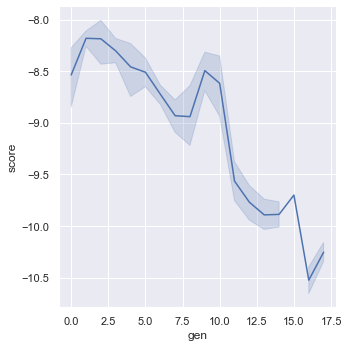

In [29]:
plt.figure(figsize=(8,6))
sns.set()
score = sns.relplot(x="gen", y="score", kind="line", data=final_joined)
plt.savefig('img/line_plot_score.svg',dpi=300)

### Binding Score and logP

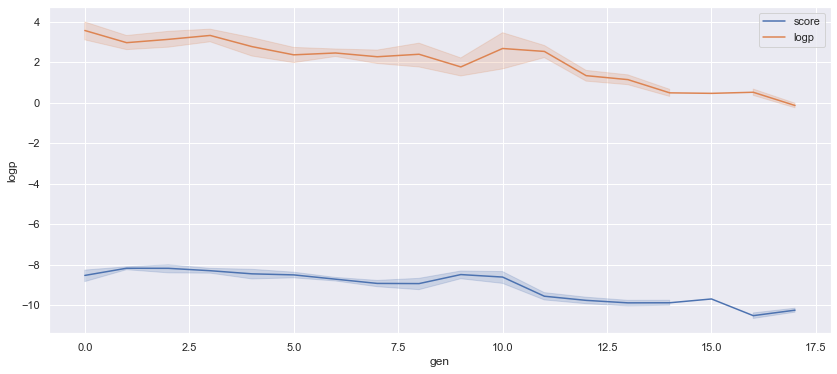

In [30]:
# Set the width and height of the figure
plt.figure(figsize=(14,6))

sns.lineplot(y=final_joined['score'],x=final_joined['gen'], label="score")
sns.lineplot(y=final_joined['logp'],x=final_joined['gen'], label="logp")

# Add label for horizontal axis
plt.xlabel("gen")

plt.savefig('img/line_plot_score_logp.svg',dpi=300)

<Figure size 1008x432 with 0 Axes>

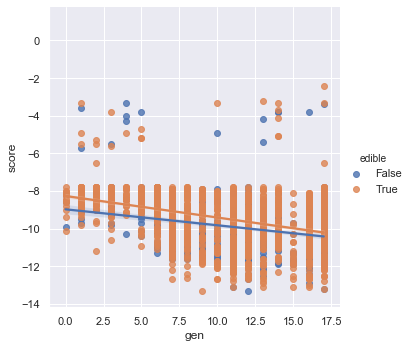

In [32]:
plt.figure(figsize=(14,6))
final["edible"] = (final_joined["logp"]<5) & (final_joined["logp"]>0)
sns.lmplot(x="gen",y="score", data=final, hue="edible")

plt.savefig('img/lm_plot_score_edible.svg',dpi=300)

### Max, Mean, Min of score

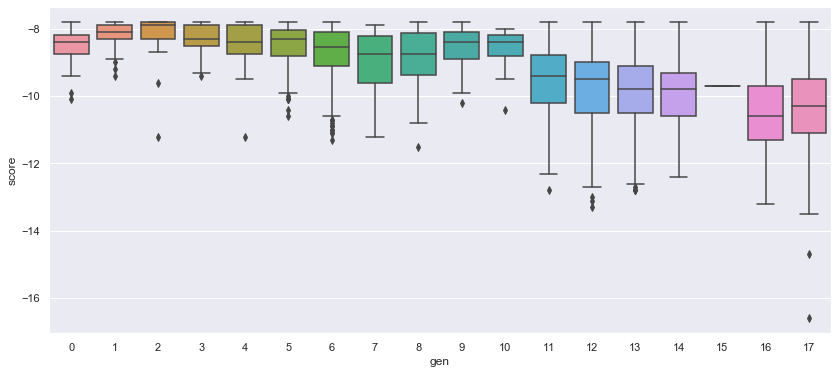

In [33]:
# Set the width and height of the figure
plt.figure(figsize=(14,6))

sns.boxplot(x="gen", y="score", data=final_joined)

# Add label for horizontal axis
plt.xlabel("gen")

sns.set()
plt.savefig('img/box_plot_score.svg',dpi=300)

### Max, Mean and Min of logP

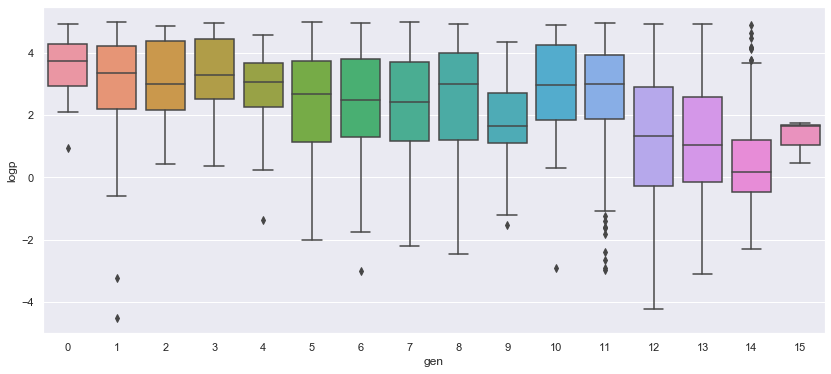

In [25]:
# Set the width and height of the figure
plt.figure(figsize=(14,6))

sns.boxplot(x="gen", y="logp", data=final_joined)

# Add label for horizontal axis
plt.xlabel("gen")

sns.set()
plt.savefig('img/box_plot_logp.svg',dpi=300)

### Gaussian of the logP

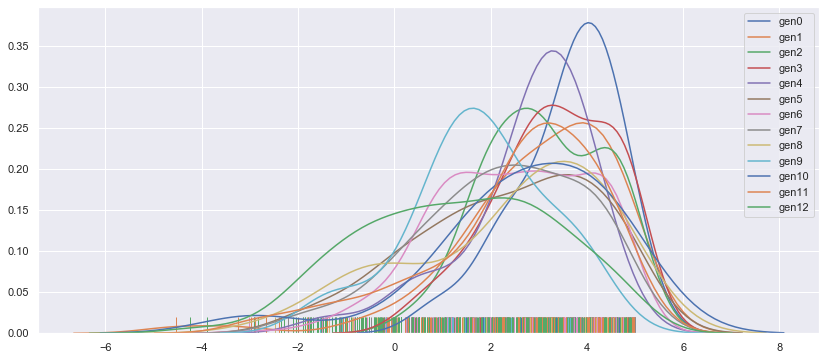

In [26]:
# Sort the dataframe by target
plt.figure(figsize=(14,6))

gen0_dist = final_joined.loc[final_joined['gen'] == 0]
gen1_dist = final_joined.loc[final_joined['gen'] == 1]
gen2_dist = final_joined.loc[final_joined['gen'] == 2]
gen3_dist = final_joined.loc[final_joined['gen'] == 3]
gen4_dist = final_joined.loc[final_joined['gen'] == 4]
gen5_dist = final_joined.loc[final_joined['gen'] == 5]
gen6_dist = final_joined.loc[final_joined['gen'] == 6]
gen7_dist = final_joined.loc[final_joined['gen'] == 7]
gen8_dist = final_joined.loc[final_joined['gen'] == 8]
gen9_dist = final_joined.loc[final_joined['gen'] == 9]
gen10_dist = final_joined.loc[final_joined['gen'] == 10]
gen11_dist = final_joined.loc[final_joined['gen'] == 11]
gen12_dist = final_joined.loc[final_joined['gen'] == 12]


sns.distplot(gen0_dist[['logp']], hist=False, rug=True, label="gen0")
sns.distplot(gen1_dist[['logp']], hist=False, rug=True, label="gen1")
sns.distplot(gen2_dist[['logp']], hist=False, rug=True, label="gen2")
sns.distplot(gen3_dist[['logp']], hist=False, rug=True, label="gen3")
sns.distplot(gen4_dist[['logp']], hist=False, rug=True, label="gen4")
sns.distplot(gen5_dist[['logp']], hist=False, rug=True, label="gen5")
sns.distplot(gen6_dist[['logp']], hist=False, rug=True, label="gen6")
sns.distplot(gen7_dist[['logp']], hist=False, rug=True, label="gen7")
sns.distplot(gen8_dist[['logp']], hist=False, rug=True, label="gen8")
sns.distplot(gen9_dist[['logp']], hist=False, rug=True, label="gen9")
sns.distplot(gen10_dist[['logp']], hist=False, rug=True, label="gen10")
sns.distplot(gen11_dist[['logp']], hist=False, rug=True, label="gen11")
sns.distplot(gen12_dist[['logp']], hist=False, rug=True, label="gen12")





### Correlations between attributes

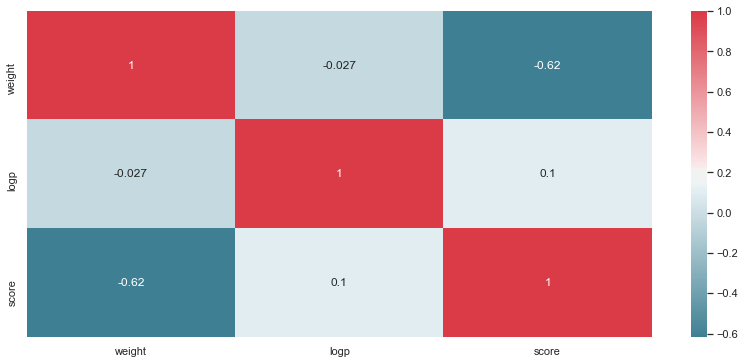

In [27]:
plt.figure(figsize=(14,6))
corr = final_joined.loc[:,final_joined.dtypes == 'float64'].corr()
sns.heatmap(corr, xticklabels=corr.columns, annot=True, yticklabels=corr.columns, cmap=sns.diverging_palette(220, 10, as_cmap=True))

### Violin Plot

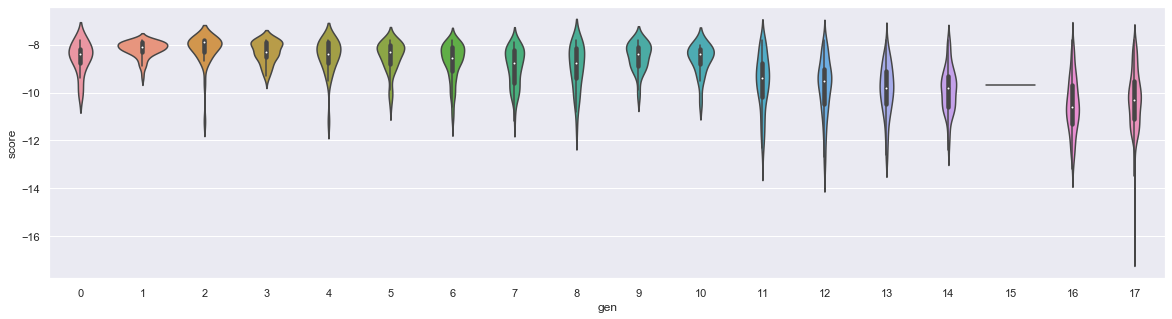

In [35]:
plt.figure(figsize=(20,5))
sns.violinplot(x="gen", y="score", data=final_joined)

sns.set()
plt.savefig('img/violin_plot_score.svg',dpi=300)

### KDE jointplot 

<Figure size 1440x360 with 0 Axes>

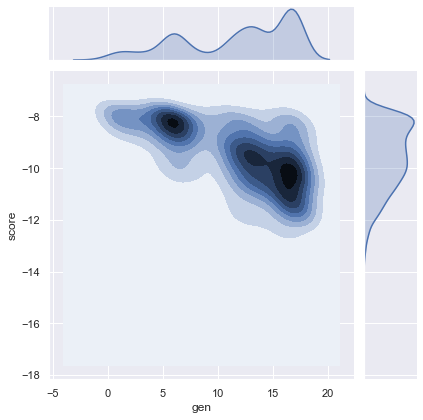

In [34]:
plt.figure(figsize=(20,5))

sns.jointplot(x="gen", y="score", data=final_joined, kind="kde")

sns.set()
plt.savefig('img/kde_joinplot_score.svg',dpi=300)